# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

Загрузим файл, подключим нужные библиотеки:

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Переведем столбцы с текстовым содержанием (Gender, Geography) к категориальному типу:

In [4]:
df[['Female', 'Male']] = pd.get_dummies(df['Gender'])
df[['France', 'Germany', 'Spain']] = pd.get_dummies(df['Geography'])
df = df.drop(df[['Gender', 'Geography']], axis=1)

Заполним пропущенные значения в столбце Tenure медианой:

In [5]:
df.loc[df['Tenure'].isna(), 'Tenure'] = df.fillna(df['Tenure'].median())

Ко всем столбцам с количественными параметрами применим технику 'Масштабирование признаков':

In [6]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']
scaler = StandardScaler()
scaler.fit(df[numeric])
df[numeric] = scaler.transform(df[numeric])

Для обучения модели разделим параметры на целевые (Exited) и не целевые (все остальные). Также удалим всю личную информацию о клиенте (столбцы 'CustomerId', 'RowNumber', 'Surname'), для обучения модели она не пригодится:

In [7]:
features = df.drop(['Exited', 'CustomerId', 'RowNumber', 'Surname'], axis=1)
target = df['Exited']

Далее разобьем данные на три части: обучающую, валидационную и тестовую в пропорции 60/20/20: 

In [8]:
features_trains, features_test, target_trains, target_test = train_test_split(features, target, test_size=0.20, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_trains, target_trains, test_size=0.25, random_state=12345)

Данные готовы.

# 2. Исследование задачи

Исследуем баланс классов:

In [9]:
target.value_counts()[1] / target.value_counts()[0]

0.25580811252040686

Баланс классов составляет 4:1. В связи с этим, для оценки моделей будем применять метрики f1 и auc_roc. Вначале исследуем алгоритмы без учета дисбаланса. Так как в столбце Exited данные категориальные, то задача сводится к бинарной классификации, нам подойдут три алгоритма обучения: дерево решений, случайный лес и логистическая регрессия. Первым исследуем "Дерево решений":

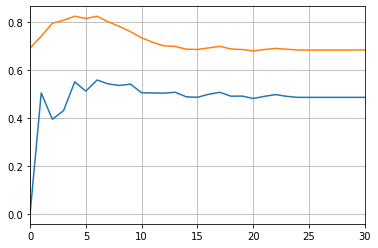

F1 наилучшей модели: 0.5574803149606299 Максимальная глубина: 7 
AUC_ROC наилучшей модели: 0.8229818206094554 Максимальная глубина: 5


In [10]:
import warnings
warnings.filterwarnings('ignore')

series_f1 = []
series_auc_roc = []

best_result_f1 = 0
best_result_auc_roc = 0

max_deep = 0
max_roc = 0

for depth in range(1, 35):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    
    predictions_valid_f1 = model.predict(features_valid)
    result_f1 = f1_score(target_valid, predictions_valid_f1)
    series_f1.append(result_f1)
    if result_f1 > best_result_f1:
        best_result_f1 = result_f1
        max_deep = depth
            
    probabilities_valid_auc_roc = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid_auc_roc[:, 1]
    result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    series_auc_roc.append(result_auc_roc)
    if result_auc_roc > best_result_auc_roc:
        best_result_auc_roc = result_auc_roc
        max_roc = depth
    
series_f1 = pd.Series(series_f1)
series_auc_roc = pd.Series(series_auc_roc)
series_f1.plot()
series_auc_roc.plot(grid=True, xlim=(0, 30))
plt.show()

print( 
    "F1 наилучшей модели:", best_result_f1, "Максимальная глубина:", max_deep,
    "\nAUC_ROC наилучшей модели:", best_result_auc_roc, "Максимальная глубина:", max_roc
)

Модель показала наилучший F1, равный 55 процентам при глубине дерева, равной 7 и наилучший AUC_ROC, равный 82 процентам при глубине дерева, равной 5. Далее исследуем алгоритм "Случайный лес":

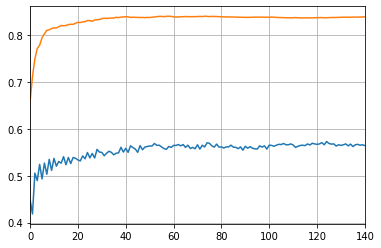

F1 наилучшей модели: 0.573268921095008 Максимальная глубина: 125 
AUC_ROC наилучшей модели: 0.8411413420990306 Максимальная глубина: 74


In [11]:
series_f1 = []
series_auc_roc = []

best_result_f1 = 0
best_result_auc_roc = 0

max_deep = 0
max_roc = 0

for depth in range(1, 150):
    model = RandomForestClassifier(random_state=12345, n_estimators=depth)
    model.fit(features_train, target_train)
    
    predictions_valid_f1 = model.predict(features_valid)
    result_f1 = f1_score(target_valid, predictions_valid_f1)
    series_f1.append(result_f1)
    if result_f1 > best_result_f1:
        best_result_f1 = result_f1
        max_deep = depth
            
    probabilities_valid_auc_roc = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid_auc_roc[:, 1]
    result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    series_auc_roc.append(result_auc_roc)
    if result_auc_roc > best_result_auc_roc:
        best_result_auc_roc = result_auc_roc
        max_roc = depth
    
series_f1 = pd.Series(series_f1)
series_auc_roc = pd.Series(series_auc_roc)
series_f1.plot()
series_auc_roc.plot(grid=True, xlim=(0, 140))
plt.show()

print( 
    "F1 наилучшей модели:", best_result_f1, "Максимальная глубина:", max_deep,
    "\nAUC_ROC наилучшей модели:", best_result_auc_roc, "Максимальная глубина:", max_roc
)

Модель показала наилучший F1, равный 57 процентам при глубине дерева, равной 125 и наилучший AUC_ROC, равный 84 процентам при глубине дерева, равной 74. Далее исследуем алгоритм "Логистическая регрессия":

In [12]:
model = LogisticRegression(random_state=12345, solver='lbfgs')
model.fit(features_train, target_train)

predictions_valid = model.predict(features_valid)
result_f1 = f1_score(target_valid, predictions_valid)

probabilities_valid_auc_roc = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid_auc_roc[:, 1]
result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print( 
    "F1 наилучшей модели:", result_f1,
    "\nAUC_ROC наилучшей модели:", result_auc_roc
)

F1 наилучшей модели: 0.30131826741996237 
AUC_ROC наилучшей модели: 0.7703264406257004


Модель показала наилучший F1, равный 30 процентам и наилучший AUC_ROC, равный 77 процентам.

### Вывод:
Ни одна из моделей не показала нужную точность. Лучший результат показал алгоритм "Случайный лес". Худший результат у алгоритма "Логистическая регрессия". Метрика AUC_ROC практически в точности повторяет линию показателя F1, указывая на эффективность модели, по сравнению с рандомной выборкой, что указывает на то, что наши модели довольно эффективны.

# 3. Борьба с дисбалансом

Для начала изменим вес класса с помощью техники 'Взвешивание классов'. Первым исследуем "Дерево решений":

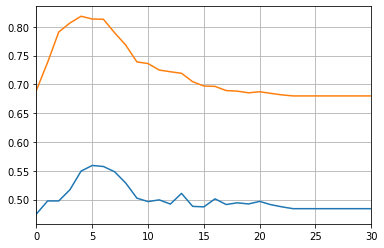

F1 наилучшей модели: 0.5591836734693878 Максимальная глубина: 6 
AUC_ROC наилучшей модели: 0.8182227845606317 Максимальная глубина: 5


In [13]:
series_f1 = []
series_auc_roc = []

best_result_f1 = 0
best_result_auc_roc = 0

max_deep = 0
max_roc = 0

for depth in range(1, 35):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    
    predictions_valid_f1 = model.predict(features_valid)
    result_f1 = f1_score(target_valid, predictions_valid_f1)
    series_f1.append(result_f1)
    if result_f1 > best_result_f1:
        best_result_f1 = result_f1
        max_deep = depth
            
    probabilities_valid_auc_roc = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid_auc_roc[:, 1]
    result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    series_auc_roc.append(result_auc_roc)
    if result_auc_roc > best_result_auc_roc:
        best_result_auc_roc = result_auc_roc
        max_roc = depth
    
series_f1 = pd.Series(series_f1)
series_auc_roc = pd.Series(series_auc_roc)
series_f1.plot()
series_auc_roc.plot(grid=True, xlim=(0, 30))
plt.show()

print( 
    "F1 наилучшей модели:", best_result_f1, "Максимальная глубина:", max_deep,
    "\nAUC_ROC наилучшей модели:", best_result_auc_roc, "Максимальная глубина:", max_roc
)

Модель показала наилучший F1, равный 55 процентам при глубине дерева, равной 6 и наилучший AUC_ROC, равный 81 процентам при глубине дерева, равной 5. Далее исследуем алгоритм "Случайный лес":

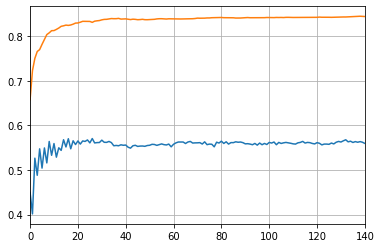

F1 наилучшей модели: 0.5705229793977813 Максимальная глубина: 27 
AUC_ROC наилучшей модели: 0.8448791087218793 Максимальная глубина: 139


In [14]:
series_f1 = []
series_auc_roc = []

best_result_f1 = 0
best_result_auc_roc = 0

max_deep = 0
max_roc = 0

for depth in range(1, 150):
    model = RandomForestClassifier(random_state=12345, n_estimators=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    
    predictions_valid_f1 = model.predict(features_valid)
    result_f1 = f1_score(target_valid, predictions_valid_f1)
    series_f1.append(result_f1)
    if result_f1 > best_result_f1:
        best_result_f1 = result_f1
        max_deep = depth
            
    probabilities_valid_auc_roc = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid_auc_roc[:, 1]
    result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    series_auc_roc.append(result_auc_roc)
    if result_auc_roc > best_result_auc_roc:
        best_result_auc_roc = result_auc_roc
        max_roc = depth
    
series_f1 = pd.Series(series_f1)
series_auc_roc = pd.Series(series_auc_roc)
series_f1.plot()
series_auc_roc.plot(grid=True, xlim=(0, 140))
plt.show()

print( 
    "F1 наилучшей модели:", best_result_f1, "Максимальная глубина:", max_deep,
    "\nAUC_ROC наилучшей модели:", best_result_auc_roc, "Максимальная глубина:", max_roc
)

Модель показала наилучший F1, равный 57 процентам при глубине дерева, равной 27 и наилучший AUC_ROC, равный 84 процентам при глубине дерева, равной 139. Далее исследуем алгоритм "Логистическая регрессия":

In [15]:
model = LogisticRegression(random_state=12345, solver='lbfgs', class_weight='balanced')
model.fit(features_train, target_train)

predictions_valid = model.predict(features_valid)
result_f1 = f1_score(target_valid, predictions_valid)

probabilities_valid_auc_roc = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid_auc_roc[:, 1]
result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print( 
    "F1 наилучшей модели:", result_f1,
    "\nAUC_ROC наилучшей модели:", result_auc_roc
)

F1 наилучшей модели: 0.47500000000000003 
AUC_ROC наилучшей модели: 0.7725311109662878


Модель показала наилучший F1, равный 47 процентам и наилучший AUC_ROC, равный 77 процентам.

### Вывод:
Ни одна из моделей не показала нужную точность. Лучший результат показал алгоритм "Случайный лес". Худший результат у алгоритма "Логистическая регрессия". Параметр class_weight='balanced' незначительно повлиял на алгоритмы "Дерево решений" и "Случайный лес". Но в значительной степени повлиял на алгоритм "Логистическая регрессия". Метрика AUC_ROC также указывает, что данные алгоритмы достаточно эффективны.

======================================================================================================================

Далее применим метод 'upsampling' и посмотрим, при какой величине таблицы будет максимальный эффект. Для начала напишем функцию, которая будет увеличивать таблицу:

In [16]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Применим данную функцию к обучающему набору данных. Найдем оптимальный размер списка для того, чтобы наши классы приблизились к балансу 1:1

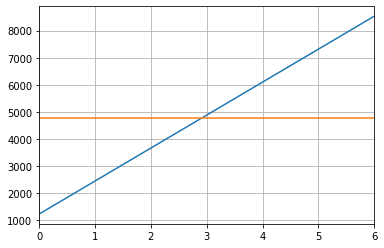

In [17]:
one = []
zero = []

for n in range(1, 8):
    features_upsampled, target_upsampled = upsample(features_train, target_train, n)
    o = target_upsampled[target_upsampled == 1].count()
    z = target_upsampled[target_upsampled == 0].count()
    
    one.append(o)
    zero.append(z)
    
one = pd.Series(one)
zero = pd.Series(zero)
one.plot()
zero.plot(grid=True)
plt.show()

Из графика видно, что оптимальный размер списка равен 3. Вызовем функцию еще раз с размером списка 3 и обучим алгоритмы с новой, сбалансированной выборкой:

In [18]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

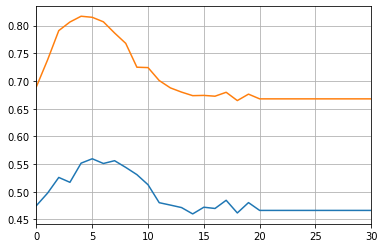

F1 наилучшей модели: 0.5595628415300545 Максимальная глубина: 6 
AUC_ROC наилучшей модели: 0.8168669202487924 Максимальная глубина: 5


In [19]:
series_f1 = []
series_auc_roc = []

best_result_f1 = 0
best_result_auc_roc = 0

max_deep = 0
max_roc = 0

for depth in range(1, 35):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    
    predictions_valid_f1 = model.predict(features_valid)
    result_f1 = f1_score(target_valid, predictions_valid_f1)
    series_f1.append(result_f1)
    if result_f1 > best_result_f1:
        best_result_f1 = result_f1
        max_deep = depth
            
    probabilities_valid_auc_roc = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid_auc_roc[:, 1]
    result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    series_auc_roc.append(result_auc_roc)
    if result_auc_roc > best_result_auc_roc:
        best_result_auc_roc = result_auc_roc
        max_roc = depth
    
series_f1 = pd.Series(series_f1)
series_auc_roc = pd.Series(series_auc_roc)
series_f1.plot()
series_auc_roc.plot(grid=True, xlim=(0, 30))
plt.show()

print( 
    "F1 наилучшей модели:", best_result_f1, "Максимальная глубина:", max_deep,
    "\nAUC_ROC наилучшей модели:", best_result_auc_roc, "Максимальная глубина:", max_roc
)

Модель показала наилучший F1, равный 55 процентам при глубине дерева, равной 6 и наилучший AUC_ROC, равный 81 процентам при глубине дерева, равной 5. Далее исследуем алгоритм "Случайный лес":

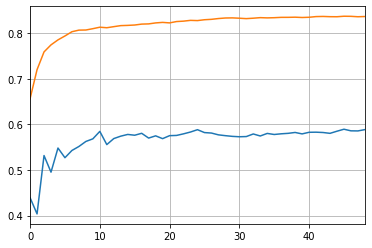

F1 наилучшей модели: 0.5895953757225433 Максимальная глубина: 46 
AUC_ROC наилучшей модели: 0.8374075492871778 Максимальная глубина: 46


In [20]:
series_f1 = []
series_auc_roc = []

best_result_f1 = 0
best_result_auc_roc = 0

max_deep = 0
max_roc = 0

for depth in range(1, 50):
    model = RandomForestClassifier(random_state=12345, n_estimators=depth)
    model.fit(features_upsampled, target_upsampled)
    
    predictions_valid_f1 = model.predict(features_valid)
    result_f1 = f1_score(target_valid, predictions_valid_f1)
    series_f1.append(result_f1)
    if result_f1 > best_result_f1:
        best_result_f1 = result_f1
        max_deep = depth
            
    probabilities_valid_auc_roc = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid_auc_roc[:, 1]
    result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    series_auc_roc.append(result_auc_roc)
    if result_auc_roc > best_result_auc_roc:
        best_result_auc_roc = result_auc_roc
        max_roc = depth
    
series_f1 = pd.Series(series_f1)
series_auc_roc = pd.Series(series_auc_roc)
series_f1.plot()
series_auc_roc.plot(grid=True)
plt.show()

print( 
    "F1 наилучшей модели:", best_result_f1, "Максимальная глубина:", max_deep,
    "\nAUC_ROC наилучшей модели:", best_result_auc_roc, "Максимальная глубина:", max_roc
)

Модель показала наилучший F1, равный 58 процентам при глубине дерева, равной 46 и наилучший AUC_ROC, равный 83 процентам при глубине дерева, равной 46. Далее исследуем алгоритм "Логистическая регрессия":

In [21]:
model = LogisticRegression(random_state=12345, solver='lbfgs')
model.fit(features_upsampled, target_upsampled)

predictions_valid = model.predict(features_valid)
result_f1 = f1_score(target_valid, predictions_valid)

probabilities_valid_auc_roc = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid_auc_roc[:, 1]
result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print( 
    "F1 наилучшей модели:", result_f1,
    "\nAUC_ROC наилучшей модели:", result_auc_roc
)

F1 наилучшей модели: 0.4778012684989429 
AUC_ROC наилучшей модели: 0.7721782365498419


Модель показала наилучший F1, равный 47 процентам и наилучший AUC_ROC, равный 77 процентам.

### Вывод:
Модель "Случайный лес" показала нужную точность. Худший результат у алгоритма "Логистическая регрессия". Сбалансирование классов незначительно повлиял на алгоритмы "Дерево решений" и "Логистическая регрессия". Но в значительной степени повлиял на алгоритм "Случайный лес". Метрика AUC_ROC также указывает, что данные алгоритмы достаточно эффективны.

# 4. Тестирование модели

В прошлом блоке у нас лидировала модель "Случайный лес", с глубиной дерева 46 и размером таблицы 3. Обучим модель на тестовой выборке и посмотрим результат F1 и выведем показатель эффективности модели auc_roc:

In [22]:
features_upsampled, target_upsampled = upsample(features_trains, target_trains, 3)

In [23]:
model = RandomForestClassifier(random_state=12345, n_estimators=37)
model.fit(features_upsampled, target_upsampled)
    
predictions_valid_f1 = model.predict(features_test)
result_f1 = f1_score(target_test, predictions_valid_f1)

probabilities_valid_auc_roc = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid_auc_roc[:, 1]
result_auc_roc = roc_auc_score(target_test, probabilities_one_valid)
    
print( 
    "F1 наилучшей модели:", result_f1,
    "\nAUC_ROC наилучшей модели:", result_auc_roc
)

F1 наилучшей модели: 0.5865257595772787 
AUC_ROC наилучшей модели: 0.8477513544577627


Модель не показала нужной нам точности на тестовой выборке. Попробуем применить метод 'Взвешивание классов' к модели-лидеру:

In [24]:
model = RandomForestClassifier(random_state=12345, n_estimators=37, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
    
predictions_valid_f1 = model.predict(features_test)
result_f1 = f1_score(target_test, predictions_valid_f1)

probabilities_valid_auc_roc = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid_auc_roc[:, 1]
result_auc_roc = roc_auc_score(target_test, probabilities_one_valid)
    
print( 
    "F1 наилучшей модели:", result_f1,
    "\nAUC_ROC наилучшей модели:", result_auc_roc
)

F1 наилучшей модели: 0.5905511811023623 
AUC_ROC наилучшей модели: 0.8460399511070151


### Вывод:

Значение F1 составляет 59 процентов, что удовлетворяет условию задачи. Адекватность данной модели выше на 34 процента по сравнению с рандомной моделью.